### XGBoost_Respiratorio e Digestivo_AD03out

### 1) arquivo SIH

### 2) respiratórias e digestivas

### 3) entorno02.

### 4) Muitos dados nulos -- poucas colunas com médias significativas


# bibliotecas

In [2]:
import plotly_express as px
# biblioteca nova, para visualização com diferentes formas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

Matplotlib is building the font cache; this may take a moment.


In [3]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

# arquivo dados_SIH_SP_2017

In [4]:
df=pd.read_csv('b_17.csv',encoding = "ISO-8859-1", low_memory=False, nrows=100000)
# somente 100 mil linhas, tempo computação adequável

In [5]:
df.head()

gid   uf_zi  ano_cmpt  mes_cmpt  espec  cgc_hosp          n_aih  ident  \
0    1  350000      2017         1      3       NaN  3517107468424      1   
1    2  350000      2017         1      3       NaN  3517107468457      1   
2    3  350000      2017         1      3       NaN  3517107468512      1   
3    4  350000      2017         1      3       NaN  3517107468600      1   
4    5  350000      2017         1      3       NaN  3517107468622      1   

       cep  munic_res  ...  tpdisec3  tpdisec4  tpdisec5  tpdisec6  tpdisec7  \
0  8665480     355250  ...         0         0         0         0         0   
1  3577030     355030  ...         0         0         0         0         0   
2  1446010     355030  ...         0         0         0         0         0   
3  5159180     355030  ...         0         0         0         0         0   
4  8830290     353060  ...         0         0         0         0         0   

   tpdisec8  tpdisec9  uf   ano  mes  
0         0         0  SP  2017    1  
1         0         0  SP  2017    1  
2         0         0  SP  2017    1  
3         0         0  SP  2017    1  
4         0         0  SP  2017    1  

[5 rows x 117 columns]

In [6]:
df.info()
# nr total de linhas correto, com um index e gid (na esquerda), que não devem ser usados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 117 entries, gid to mes
dtypes: float64(15), int64(89), object(13)
memory usage: 89.3+ MB


In [7]:
df.isnull().sum() 
# não temos nulos, ok.

gid         0
uf_zi       0
ano_cmpt    0
mes_cmpt    0
espec       0
           ..
tpdisec8    0
tpdisec9    0
uf          0
ano         0
mes         0
Length: 117, dtype: int64

# seleção de features_resprt_digest

In [8]:
# Doenças do aparelho respiratório J00-J99,
# Doenças do aparelho digestivo    K00-K93
# Separação das doenças do sistema digestivo especificamente -- grupo CID10 = K20 -K93

In [9]:
df1=pd.DataFrame(df,columns=['munic_res', 'diag_princ'])
print(df1.shape)
df1.sample(3)

(100000, 2)


munic_res diag_princ
9974      351380       O420
96808     350170       Q780
54718     350600       M899

In [10]:
dados = df1.loc[:, ['munic_res','diag_princ']]
# subconjunto_chave primária_doença
dados['subgrupo'] = dados['diag_princ'].astype(str).str.slice(0,1)
#focar na letra_inicial, criando uma coluna específica subgrupo, só com a letra K ou J
temp = np.where(dados['subgrupo'].isin(['K', 'J']))
#específico para K e J
dados = dados.loc[temp]
# reunir tudo
dados.sample(3)

munic_res diag_princ subgrupo
15992     355030       K402        K
75787     351510       J960        J
78701     352250       J180        J

In [11]:
dados['munic_res'] = dados['munic_res'].astype(str)
# troca para str para junção posterior com entorno02

In [13]:
dados.info(verbose=True)
# munic_res é now = "object"
# confirmação do tipo das variáveis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 19 to 99995
Data columns (total 3 columns):
munic_res     16214 non-null object
diag_princ    16214 non-null object
subgrupo      16214 non-null object
dtypes: object(3)
memory usage: 506.7+ KB


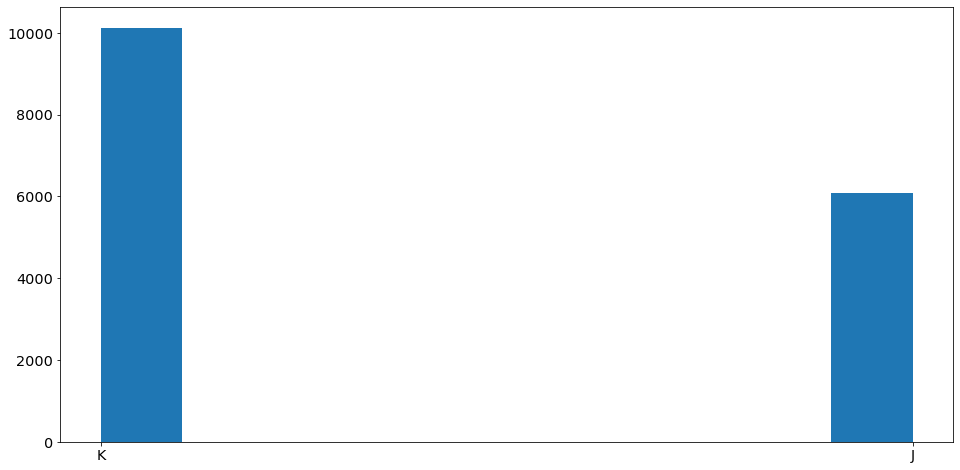

In [14]:
h = plt.hist(dados['subgrupo'])
plt.show()
# J = respiratório K = digestivo
# comparação entre os dois grupos: quase 2(d) x 1(r)

## features = colunas = significado

#### Acoplamento com arquivo entorno SP02 (cidades diferentes da Capital)
#### Col: e02 [Sit_set, 206,254,260,262,264,266,268,270,272,358,360,362,364,366,368,370,372,374,376,378)]
#### chave primária deverá ser "Cod_setor", derivada do "munic_res"
#### V206 = domicílios com moradia inadequada - existe ident. logradouro
#### V254 = domicilios com moradia permanente inadequada -- existe lixo a céu aberto
#### V256 = domicilios com moradia permanente adequada -- existe lixo a céu aberto
#### V260 = domicilios com moradia permanente inadequada -- existe lixo acumulado
#### V262 = domicilios com moradia permanente até 1/4 SM
#### V264 = domicilios com moradia permanente 1/4 a 1/2 SM
#### V266 = domicilios com moradia permanente 1/2 a 1 SM
#### V268 = domicilios com moradia permanente 1 a 2 SM
#### V270 = domicilios com moradia permanente mais de 2SM
#### V272 = domicilios com moradia permanente sem rendimento nominal
#### V358 = domicilios com moradia permanente até 1/4 SM -- existe esgoto a céu aberto
#### V360 = domicilios com moradia permanente  1/4  a 1/2 SM -- existe esgoto a céu aberto
#### V362 = domicilios com moradia permanente 1/2 a 1 SM -- existe esgoto a céu aberto
#### V364 = domicilios com moradia permanente 1 a 2 SM -- existe esgoto a céu aberto
#### V366 = domicilios com moradia permanente mais de 2 SM -- existe esgoto a céu aberto
#### V368 = domicilios com moradia permanente sem rendimento nominal -- existe esgoto a céu aberto
#### V370 = domicilios com moradia permanente até 1/4 SM  --  existe lixo acumulado
#### V372 = domicilios com moradia permanente 1/4 & 1/2 SM  --  existe lixo acumulado
#### V374 = domicilios com moradia permanente 1/2 & 1 SM  --  existe lixo acumulado
#### V376 = domicilios com moradia permanente 1 & 2 SM  --  existe lixo acumulado
#### V378 = domicilios com moradia permanente mais de 2 SM  --  existe lixo acumulado
#### V380 = domicilios com moradia permanente sem rendimento  --  existe lixo acumulado

In [15]:
pd.set_option('display.max_columns', None)  

### Opção: colunas e02 

In [16]:
a=pd.read_csv(r'e02_SP2.csv', sep=";",decimal='.',encoding = 'latin', low_memory=False, error_bad_lines=False, index_col=False, nrows=8000)

In [17]:
a['Cod_setor'] = a['Cod_setor'].astype(str).str.slice(0,6)
a.rename(columns={'Cod_setor':'munic_res'}, inplace=True)
print(a.shape)
a.sample(3)

(8000, 222)


munic_res  Situacao_setor  V202  V203  V204  V205  V206  V207  V208  \
7619    350950               1   129   130    10    13     0     0   259   
3194    350530               1    74    74     0     0     0     0   148   
3496    350571               1   246    10     0     0     0     0   256   

      V209  V210  V211  V212  V213  V214  V215  V216  V217  V218  V219  V220  \
7619     0    23     0     0     0   259     0    23     0     0     0   259   
3194     0     0     0     0     0   148     0     0     0     0     0   148   
3496     0     0     0     0     0   256     0     0     0     0     0   255   

      V221  V222  V223  V224  V225  V226  V227  V228  V229  V230  V231  V232  \
7619     0    23     0     0     0   259     0    23     0     0     0   118   
3194     0     0     0     0     0   148     0     0     0     0     0    21   
3496     1     0     0     0     0   254     2     0     0     0     0   137   

      V233  V234  V235  V236  V237  V238  V239  V240  V241  V242  V243  V244  \
7619   141    10    13     0     0     0   259     0    23     0     0   256   
3194   127     0     0     0     0    14   134     0     0     0     0   141   
3496   119     0     0     0     0     0   256     0     0     0     0   208   

      V245  V246  V247  V248  V249  V250  V251  V252  V253  V254  V255  V256  \
7619     3    23     0     0     0    10   249     1    22     0     0    10   
3194     7     0     0     0     0     0   148     0     0     0     0     0   
3496    48     0     0     0     0     0   256     0     0     0     0     0   

      V257  V258  V259  V260  V261  V262  V263  V264  V265  V266  V267  V268  \
7619   249     1    22     0     0     5     3    16    20    39    45    65   
3194   148     0     0     0     0     1     2     3     2    23     6    17   
3496   256     0     0     0     0    14     0    72     2    83     4    37   

      V269  V270  V271  V272  V273  V274  V275  V276  V277  V278  V279  V280  \
7619    51    12    17     2     7     8     0    36     0    84     0   116   
3194    21    29    43     1     0     3     0     5     0    29     0    38   
3496     3    11     0    29     1    14     0    74     0    87     0    40   

      V281  V282  V283  V284  V285  V286  V287  V288  V289  V290  V291  V292  \
7619     0    29     0     9     0     8     0    36     0    84     0   116   
3194     0    72     0     1     0     3     0     5     0    29     0    38   
3496     0    11     0    30     0    14     0    74     0    87     0    40   

      V293  V294  V295  V296  V297  V298  V299  V300  V301  V302  V303  V304  \
7619     0    29     0     9     0     8     0    36     0    84     0   116   
3194     0    72     0     1     0     3     0     5     0    29     0    38   
3496     0    11     0    30     0    14     0    73     1    87     0    40   

      V305  V306  V307  V308  V309  V310  V311  V312  V313  V314  V315  V316  \
7619     0    29     0     9     0     8     0    36     0    84     0   116   
3194     0    72     0     1     0     3     0     5     0    29     0    38   
3496     0    11     0    30     0    14     0    73     1    87     0    40   

      V317  V318  V319  V320  V321  V322  V323  V324  V325  V326  V327  V328  \
7619     0    29     0     9     0     5     3    22    14    32    52    55   
3194     0    72     0     1     0     1     2     0     5     5    24     4   
3496     0    11     0    29     1     6     8    40    34    46    41    21   

      V329  V330  V331  V332  V333  V334  V335  V336  V337  V338  V339  V340  \
7619    61    14    15     0     9     0     8     0    36     0    84     0   
3194    34    11    61     0     1     0     3     0     5     5    24     5   
3496    19     5     6    19    11     0    14     0    74     0    87     0   

      V341  V342  V343  V344  V345  V346  V347  V348  V349  V350  V351  V352  \
7619   116     0    29     0     9     8     0    34     2    83     1   116   
3194    3

In [18]:
a.info(verbose=True)
# munic_res = "object"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 222 columns):
munic_res         object
Situacao_setor    int64
V202              int64
V203              int64
V204              int64
V205              int64
V206              int64
V207              int64
V208              int64
V209              int64
V210              int64
V211              int64
V212              int64
V213              int64
V214              int64
V215              int64
V216              int64
V217              int64
V218              int64
V219              int64
V220              int64
V221              int64
V222              int64
V223              int64
V224              int64
V225              int64
V226              int64
V227              int64
V228              int64
V229              int64
V230              int64
V231              int64
V232              int64
V233              int64
V234              int64
V235              int64
V236              int64
V23

### Seleção de colunas para dataframe específico

In [19]:
a1 = a.loc[:, ['munic_res','Situacao_setor','V206','V254','V256','V260','V262','V264','V266','V268','V270','V272','V358','V360','V362','V364','V366','V368','V370','V372','V374','V376','V378','V380']]

In [20]:
a1.head(2)

munic_res  Situacao_setor  V206  V254  V256  V260  V262  V264  V266  V268  \
0    350011               1     0     0     0     0     0     1    22    42   
1    350011               1     0     0     0     0     0    15    59    87   

   V270  V272  V358  V360  V362  V364  V366  V368  V370  V372  V374  V376  \
0    79     3     0     0     0     0     0     0     0     0     0     0   
1    91     4     0     0     0     0     0     0     0     0     0     0   

   V378  V380  
0     0     0  
1     0     0

## Muitos dados nulos. Opção = retirá-los.

In [21]:
a1 = a.loc[:, ['munic_res','Situacao_setor','V262','V264','V266','V268','V270','V272']]

In [22]:
mg = pd.merge(dados,a1,on='munic_res', how='inner')
# junção dos arquivos, naquilo que for comum aos dois, pelo "munic_res"

In [23]:
mg.info(verbose=True)
# nr de linhas muito maior do que esperado, pode haver duplicação desnecessária

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478111 entries, 0 to 478110
Data columns (total 10 columns):
munic_res         478111 non-null object
diag_princ        478111 non-null object
subgrupo          478111 non-null object
Situacao_setor    478111 non-null int64
V262              478111 non-null int64
V264              478111 non-null int64
V266              478111 non-null int64
V268              478111 non-null int64
V270              478111 non-null int64
V272              478111 non-null int64
dtypes: int64(7), object(3)
memory usage: 40.1+ MB


In [24]:
mg.drop_duplicates(inplace=True)
# retirada de duplicações eventuais

In [25]:
mg.dropna

<bound method DataFrame.dropna of        munic_res diag_princ subgrupo  Situacao_setor  V262  V264  V266  V268  \
0         350850       K409        K               1     0     1     7    18   
1         350850       K409        K               1     2    10    43    67   
2         350850       K409        K               1     8     7    39    51   
3         350850       K409        K               1     5    17    42    46   
4         350850       K409        K               1     2     8    28    73   
...          ...        ...      ...             ...   ...   ...   ...   ...   
478100    350110       J188        J               1     1    17    84    62   
478101    350110       J188        J               3     0     0     0     0   
478102    350110       J188        J               8     0     0     0     0   
478107    350110       J188        J               1     7    37    78    25   
478109    350110       J188        J               1     5    11    31    17   

     

In [26]:
mg.astype({'munic_res': 'int32'}).dtypes
# alteração do munic_res para int32

munic_res          int32
diag_princ        object
subgrupo          object
Situacao_setor     int64
V262               int64
V264               int64
V266               int64
V268               int64
V270               int64
V272               int64
dtype: object

In [27]:
mg.isnull().sum().sum()

0

In [28]:
mg.isna().values.sum()

0

### Fim da preparação de arquivo para Regressões.

## XGBoost_desenvolvimento

### importação_bibliotecas

In [29]:
! pip install lightgbm
! pip install xgboost

### divisão_X(entrada=features)_y(saída=subgrupo)

In [63]:
y = mg.loc[:,'subgrupo'] # variável a ser predita, ou variável explicada
X = mg.drop(['diag_princ','subgrupo'], axis=1) 

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
from sklearn import preprocessing
le = preprocessing.LabelBinarizer()
y = le.fit_transform(y)
y = np.ravel(y)

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

In [67]:
X_train.shape, y_train.shape

((136310, 8), (136310,))

In [68]:
X_test.shape, y_test.shape

((58419, 8), (58419,))

### Avaliação das features

In [36]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [37]:
print(model.feature_importances_)
# temos 8 variáveis explicativas

[0.52216172 0.00629023 0.0578461  0.08096875 0.08638623 0.09345145
 0.09288383 0.06001169]


<AxesSubplot:>

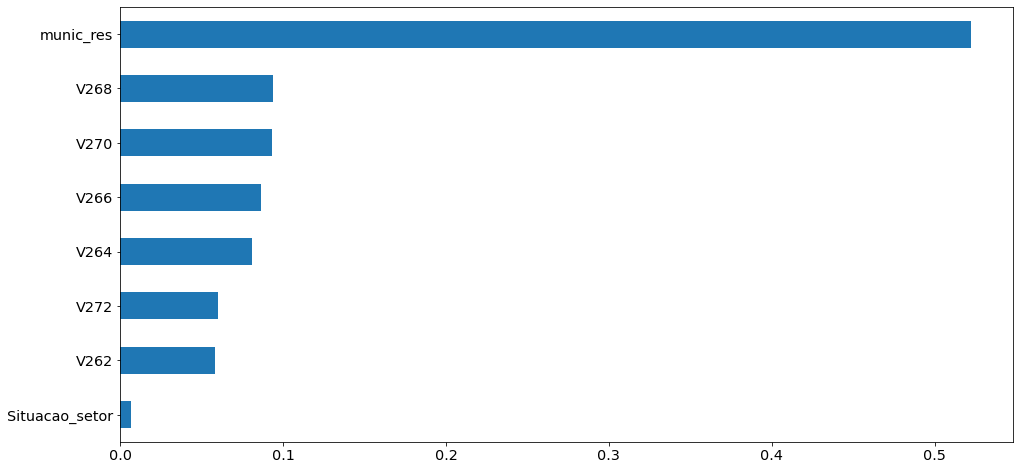

In [40]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(8).sort_values().plot.barh())
# apresentação das features por importância - para se escolher quais devem permanecer

In [42]:
# seleção de algumas variáveis, escolhendo as colunas que nos interessam para prosseguir. Teremos somente as colunas
# das variáveis indicadas acima, começando com Pregnancies, Glucose etc...
x0=X.iloc[:,0]
x1=X.iloc[:,1]
x2=X.iloc[:,2]
x3=X.iloc[:,3]
x4=X.iloc[:,4]
x5=X.iloc[:,5]
x6=X.iloc[:,6]
xnew=np.column_stack((x0,x1,x2,x3,x4,x5,x6))
xnew
# feito um novo dataframe somente com as colunas selecionadas, tendo as mesmas 768 linhas.
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(xnew,y,random_state=0)

## Comparação entre Regressão Logística x BoostingClassifiers

In [43]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression().fit(x_train,y_train)
logreg
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(x_train, y_train)
#  LightGBM Classifier
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb_model.fit(x_train, y_train)
 # XGBoost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb_model.fit(x_train, y_train)
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.001)
ada_clf.fit(x_train, y_train)

print('*****************ClassifiersDone*****************')

C:\Users\aferr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



*****************ClassifiersDone*****************


### Pontuações Obtidas depois da comparação

In [44]:
# Fase de treino apenas, uso de todos os modelos
# Pode acontecer dos modelos aprenderem os erros, o que pode ser tolerável no treino. Mas, no teste, isso pode ser um problema.
models=['Logistic','GradientBoost','LightGBM','XGBoost','AdaBoost']
Trainning_Accuracy=[logreg.score(x_train,y_train),
                    gbrt.score(x_train, y_train),
                    lgb_model.score(x_train, y_train),
                    xgb_model.score(x_train, y_train), 
                    ada_clf.score(x_train, y_train)]
Validation_Accuracy=[logreg.score(x_val, y_val),
                    gbrt.score(x_val, y_val),
                    lgb_model.score(x_val, y_val),
                    xgb_model.score(x_val, y_val), 
                    ada_clf.score(x_val, y_val)]
pd.DataFrame(list(zip(Trainning_Accuracy, Validation_Accuracy)), 
                  columns =['Trainning_Accuracy', 'Validation_Accuracy'],
                  index=models)

Trainning_Accuracy  Validation_Accuracy
Logistic                 0.673178             0.673212
GradientBoost            0.676396             0.675308
LightGBM                 0.673178             0.673212
XGBoost                  0.673178             0.673212
AdaBoost                 0.673178             0.673212

In [69]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
sc.fit(X_train)
X_train_st = sc.transform(X_train) 
X_test_st = sc.transform(X_test)

### REGRESSÂO LOGÍSTICA -- matriz de confusão

In [70]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state=1234, solver = 'lbfgs')
log.fit(X_train_st,y_train)
log_pred = log.predict(X_test_st)
log_cm = confusion_matrix(y_test,log_pred)

acuracia_log = accuracy_score(y_pred=log_pred,y_true=y_test)
precisao_log = precision_score(y_pred=log_pred,y_true=y_test)
recall_log = recall_score(y_pred=log_pred,y_true=y_test)

In [71]:
print(acuracia_log,precisao_log,recall_log)
print(log_cm)

0.6729831048117907 0.6729831048117907 1.0
[[    0 19104]
 [    0 39315]]


### GRADIENT BOOST CLASSIFIER -- matriz de confusão

In [76]:
grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(X_train_st, y_train)
grbt_pred=grbt.predict(X_test_st)
grbt_cm=confusion_matrix(y_test,grbt_pred)
acuracia_grbt = accuracy_score(y_pred=grbt_pred,y_true=y_test)
precisao_grbt = precision_score(y_pred=grbt_pred,y_true=y_test)
recall_grbt = recall_score(y_pred=grbt_pred,y_true=y_test)

In [77]:
print(acuracia_log,precisao_log,recall_log)
print(grbt_cm)

0.6729831048117907 0.6729831048117907 1.0
[[  486 18618]
 [  375 38940]]


### EXTREME GRADIENT BOOST CLASSIFIER XGBOOST -- matriz de confusão

In [78]:
xgboost = xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgboost.fit(X_train_st, y_train)
xgboost_pred=grbt.predict(X_test_st)
xgboost_cm=confusion_matrix(y_test,xgboost_pred)
acuracia_xgboost = accuracy_score(y_pred=xgboost_pred,y_true=y_test)
precisao_xgboost = precision_score(y_pred=xgboost_pred,y_true=y_test)
recall_xgboost = recall_score(y_pred=xgboost_pred,y_true=y_test)

In [79]:
print(acuracia_xgboost,precisao_xgboost,recall_xgboost)
print(xgboost_cm)

0.6748831715708931 0.6765349734181174 0.9904616558565433
[[  486 18618]
 [  375 38940]]
